This second spreadsheet is to simply test some different parameters with the random forest model to see if they need to be adjusted to improve performance. I did learn that if you run a model a second time without ru-running the validation split with the random seed set, the results aren't repeatable. This happened with version 5 below. I did get a better Kaggle score, but I can't repeat the results. Good lesson. 

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Below are all the preprocessing steps for the train and test dataframes from the part 1 worksheet. 

In [5]:
modes = train.mode().iloc[0]
train.fillna(modes, inplace=True)
cont,cat = cont_cat_split(train)
for i in cat:
    train[i] = pd.Categorical(train[i])
cat.remove('Transported')
dep='Transported'

In [6]:
modes_test = test.mode().iloc[0]
test.fillna(modes_test, inplace=True)
test_passid = pd.DataFrame(test['PassengerId'])
test_cont,test_cat = cont_cat_split(test)
for i in test_cat:
    test[i] = pd.Categorical(test[i])
test_passid['PassIdCode'] = test.PassengerId.cat.codes

# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(train, test_size=0.25)

#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

Then I'm using this function to return the independent (trn_xs and val_xs) and the dependent variables (trn_y and val_y).

In [8]:
def xs_y(df):
    xs = df[cat+cont].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

The separation appeared to work. 

In [9]:
trn_xs.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5623,5981_01,Mars,False,F/1140/S,TRAPPIST-1e,False,Harz Quart,27.0,441.0,0.0,397.0,471.0,0.0
5253,5606_01,Europa,True,B/213/S,55 Cancri e,False,Algor Paterpad,45.0,0.0,0.0,0.0,0.0,0.0
478,0515_01,Europa,True,B/20/S,TRAPPIST-1e,False,Alramix Swinvul,50.0,0.0,0.0,0.0,0.0,0.0
1352,1425_02,Earth,True,G/220/P,TRAPPIST-1e,False,Mael Adavisons,1.0,0.0,0.0,0.0,0.0,0.0
5344,5713_01,Earth,False,G/915/P,TRAPPIST-1e,False,Lawren Blangibson,42.0,0.0,29.0,317.0,434.0,45.0


In [10]:
trn_y.head()

5623    False
5253     True
478      True
1352     True
5344     True
Name: Transported, dtype: category
Categories (2, object): [False, True]

These lambda functions return all the categorical data in the training and validation datasets for the independent variables into continuous values.

In [11]:
trn_xs[cat] = trn_xs[cat].apply(lambda x: x.cat.codes)
val_xs[cat] = val_xs[cat].apply(lambda x: x.cat.codes)

Below the dependent Transported categorical data are turned into continuous data. 

In [12]:
trn_y = pd.Categorical(trn_y).codes
val_y = pd.Categorical(val_y).codes

In [13]:
trn_y

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [15]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.20929162833486661

In [16]:
mean_absolute_error(trn_y, rf.predict(trn_xs))

0.10369688602546402

From here I'll look at modifying the two main random forest parameters to see if there is any meaningful improvement. 

In [16]:
rf1 = RandomForestClassifier(50, min_samples_leaf=5)
rf1.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf1.predict(val_xs))

0.20515179392824287

In [15]:
rf2 = RandomForestClassifier(150, min_samples_leaf=5)
rf2.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf2.predict(val_xs))

0.20837166513339467

In [15]:
rf3 = RandomForestClassifier(100, min_samples_leaf=4)
rf3.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf3.predict(val_xs))

0.21113155473781048

In [15]:
rf4 = RandomForestClassifier(100, min_samples_leaf=6)
rf4.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf4.predict(val_xs))

0.20745170193192272

In [15]:
rf5 = RandomForestClassifier(100, min_samples_leaf=7)
rf5.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf5.predict(val_xs))

0.20975160993560257

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

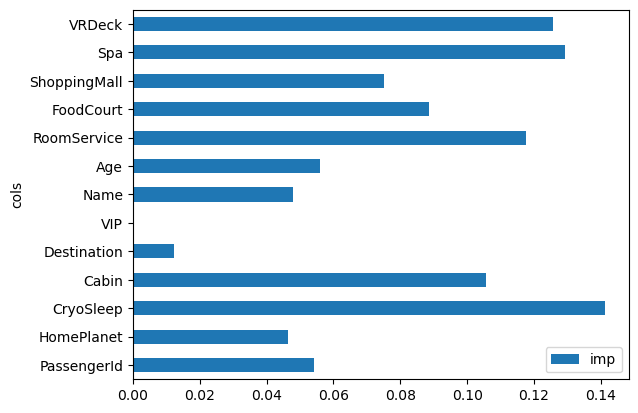

In [16]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf5.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

I uploaded the submission file and compared it to the test file to make sure it had the same number of rows and that the the Passengerid seemed the same. 

In [23]:
submit = pd.read_csv('sample_submission.csv')

In [24]:
submit.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [25]:
submit.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,False
freq,1,4277


In [26]:
test['PassengerId'].describe()

count        4277
unique       4277
top       0013_01
freq            1
Name: PassengerId, dtype: object

In [27]:
test['PassengerId'].head()

0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: PassengerId, dtype: category
Categories (4277, object): ['0013_01', '0018_01', '0019_01', '0021_01', ..., '9269_01', '9271_01', '9273_01', '9277_01']

First I'm converting the test dataset categorical data into their continuous values. Then I'm using the function I used earlier to classify all the current columns in the test dataset as independent variables. 

In [28]:
test[test_cat] = test[test_cat].apply(lambda x: x.cat.codes)
test_xs,_ = xs_y(test)

In [29]:
test_xs

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,0,1,2784,2,0,2912,27.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1867,2,0,2406,19.0,0.0,9.0,0.0,2823.0,0.0
2,2,1,1,257,0,0,3376,31.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,259,2,0,2711,38.0,0.0,6652.0,0.0,181.0,585.0
4,4,0,0,1940,2,0,668,20.0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,4272,0,1,2679,2,0,2105,34.0,0.0,0.0,0.0,0.0,0.0
4273,4273,0,0,2691,2,0,2654,42.0,0.0,847.0,17.0,10.0,144.0
4274,4274,2,1,602,0,0,2085,18.0,0.0,0.0,0.0,0.0,0.0
4275,4275,1,0,603,2,0,2327,18.0,0.0,2680.0,0.0,0.0,523.0


I'm creating the new Transported column in the test dataset as the dependent variable and running the random forest prediction model against the test data. 

In [30]:
test['Transported'] = rf5.predict(test_xs)

In [31]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


I need to rename the PassengerId column into a PassCode column so I can next work to match the coded continuous data back to its original categorical data. 

In [32]:
test.rename(columns={'PassengerId': 'PassCode'}, inplace=True)

In [33]:
test.head()

,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


I need to create a PassengerID categorical data column in the test dataset to match what is in the submit dataset. So where the PassIDCode column from the test_passid dataframe I created earlier matches the PassCode column in the test dataframe, then th PassengerId column in the test dataframe will be filled with the PassengerId value from this earlier test_passid dataframe. Otherwise a NaN value will be created.  

In [34]:
#YES
test['PassengerId'] = np.where(test_passid['PassIdCode'] == test['PassCode'], test_passid['PassengerId'], 'NaN')

In [35]:
test.head()

,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1,0013_01
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0,0018_01
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1,0019_01
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1,0021_01
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0,0023_01


Below I'm making sure there are no NaN values for the new PassengerId column. 

In [36]:
test['PassengerId'].isna().sum()

0

I'm just moving the PassengerId to the front of the datafram here. 

In [37]:
#TEST
col = test.pop('PassengerId')
test.insert(0, col.name, col)

In [38]:
test.head()

,PassengerId,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,0018_01,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,0019_01,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,0021_01,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,0023_01,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


Here I'm converting the Transported column back into the True/False boolean values that will be needed for submission. 

In [39]:
test['Transported'] = np.where(test['Transported'] == 1, 'True', 'False')

In [40]:
test.head()

,PassengerId,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,True
1,0018_01,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,False
2,0019_01,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,True
3,0021_01,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,True
4,0023_01,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,False


This creates the actual submission file with this initial benchmark random forest model. 

In [41]:
#YES
submit_benchmark = test[['PassengerId', 'Transported']]

In [42]:
submit_benchmark.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [43]:
#YES
submit_benchmark.to_csv('submit_benchmark_rf5.csv', index=False)

For the original submission of rf1 I received a score of 0.79027 which which is lower than my first submission. For the next submission of rf5 I received a score of 0.79284 which improved me to 1177 out of 2308 for the 49th percentile. HOWEVER, THIS TURNED OUT TO BE FLAWED AS I RAN IT AFTER RUNNING ANOTHER MODEL VERSION AND NOT BEFORE RE-RUNNING THE VALIDATION SPLIT. I CAN'T REPEAT THIS RESULT. 